In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import itertools
import seaborn as sns

In [2]:
# we load our dataset
file_path = "Shloshim.xlsx"
df = pd.read_excel(file_path, sheet_name=0)

# we rename columns
df.rename(columns={
    'Date': 'Date',
    'NVDA UW Equity - Last Price': 'NVDA',
    'AMD UW Equity - Last Price': 'AMD'
}, inplace=True)

# we set our datetime exit
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df = df.sort_index(ascending=True)
df[["NVDA", "AMD"]] = df[["NVDA", "AMD"]].interpolate()
df.dropna(subset=["NVDA", "AMD"], inplace=True)

df = df.sort_index()

In [3]:
# cleaning the dataset 

# # first we check for the missing values 
# # Check for missing values in each column
# missing_values = df.isnull().sum()
# missing_values

# # since there is only one missing row, then interpolate
# df.interpolate(method='linear', inplace=True)

# # confirming that missing values are handled
# missing_2 = df.isnull().sum()
# missing_2

num_cols = ["NVDA", "AMD"]  
df[num_cols] = df[num_cols].interpolate()  
df.dropna(subset=num_cols, inplace=True)    
# we set initial time to 0
df["NVDA_i"] = df["NVDA"] / df["NVDA"].iloc[0]
df["AMD_i"]  = df["AMD"]  / df["AMD"].iloc[0]
display(df.head())

,NVDA,AMD,NVDA_i,AMD_i
Date,,,,
2020-03-16,4.9100,38.71,1.000000,1.000000
2020-03-17,5.4317,41.88,1.106253,1.081891
2020-03-18,5.0705,39.12,1.032688,1.010592
2020-03-19,5.3243,39.82,1.084379,1.028675
2020-03-20,5.1438,39.61,1.047617,1.023250


In [ ]:
# we run a Kalman filter for βₜ 
df = df.sort_index(ascending=True)
def kalman_beta(y, x, q= 0.001, r= 1.0, beta0=0.0, P0=1.0):
    """Return series of time‑varying hedge ratios βₜ."""
    l = len(x)
    beta = np.empty(l)
    P = np.empty(l)

    beta[0], P[0] = beta0, P0

    for t in range(1, l):
        xt = x[t]
        yt = y[t]
        P_pred = P[t-1] + q
        K_t = P_pred * xt / (xt**2 * P_pred + r)
        beta[t] = beta[t-1] + K_t * (yt - beta[t-1] * xt)
        P[t] = (1 - K_t * xt) * P_pred

    return beta

y = df["NVDA"].values
x = df["AMD"].values

dbeta = kalman_beta(y, x)


# We want to run the filter without the first 30 values in order to account for 
# instability in the first few rescursive values
exclusion = 30
df = df.iloc[exclusion:].copy()
dbeta = dbeta[exclusion:]  # match df length

# We assign hedge ratio and compute spread
df["dbeta"] = dbeta
df["dspread"] = df["NVDA"] - df["dbeta"] * df["AMD"]


adf_stat, p_val, *_ = adfuller(df["dspread"])
print(f"ADF stat = {adf_stat:.3f},  p‑value = {p_val:.4f}")

# the ADF stat and the p value are almost too perfect. vary q and r to make sure there isnt overfitting 

Intercept α  : -51.809697
Hedge ratio β:  0.891898
ADF stat = -0.430,  p‑value = 0.9050


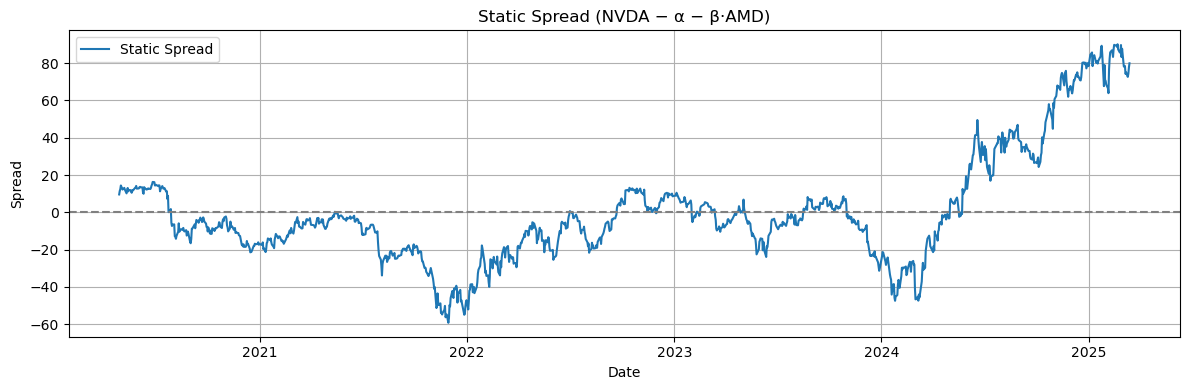

In [5]:
# computing the intitial hedge ratio
# this ratio tells us how many of AMD we need to buy to hedge NVDA 
# We being sorting the dataset
df = df.sort_index(ascending=True)
 

# We define out price series taking NVIDIA as our 
Y = df['NVDA']
X = df['AMD']

# We add a constant term
X_const = sm.add_constant(X)

# We initialize a linear ression model
model= sm.OLS(Y, X_const).fit()
beta = model.params['AMD']
alpha = model.params['const']

print(f"Intercept α  : {alpha: .6f}")
print(f"Hedge ratio β: {beta: .6f}")

# We compute stationaryspread
df["static_spread"] = Y - (alpha + beta * X)

# We initialize an ADF test for stationarity
adf_stat, p_val, *_ = adfuller(df["static_spread"].dropna())
print(f"ADF stat = {adf_stat:.3f},  p‑value = {p_val:.4f}")

# We plot the static spread to ascertain its behaviour 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(df.index, df["static_spread"], label="Static Spread")
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Spread")
plt.title("Static Spread (NVDA − α − β·AMD)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

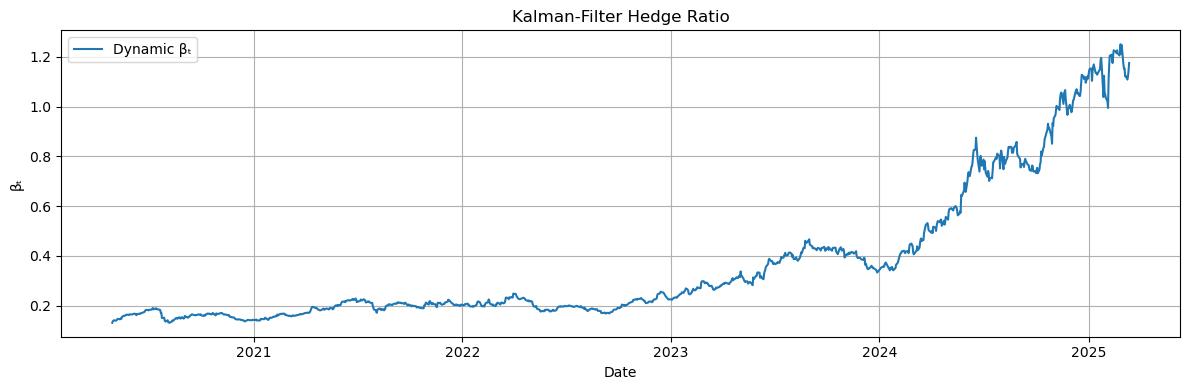

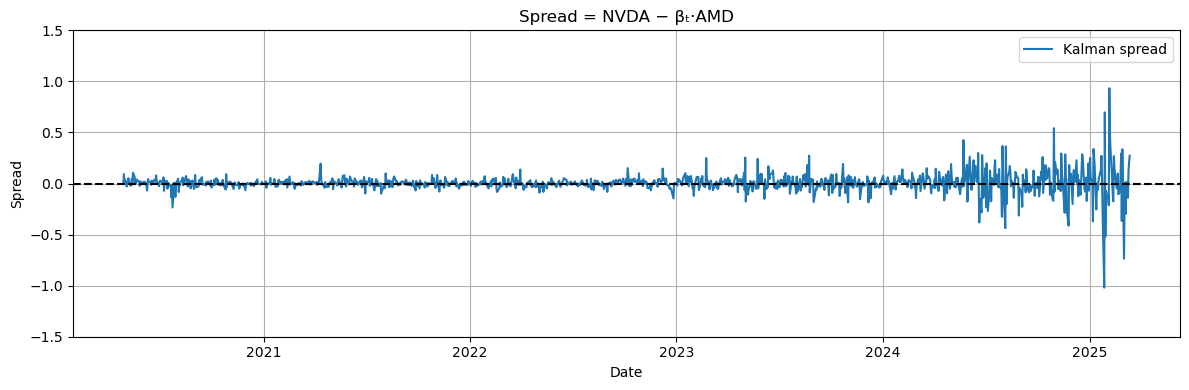

In [6]:
# We plot Hedge ratio in order to understand its behaviour over time 
plt.figure(figsize=(12, 4))
plt.plot(df.index, dbeta, label="Dynamic βₜ")
plt.title("Kalman‑Filter Hedge Ratio")
plt.xlabel("Date");  plt.ylabel("βₜ")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# 8We plot spread in order to understand its behaviour with a dynamic hedge ratio
plt.figure(figsize=(12, 4))
plt.plot(df.index, df["dspread"], label="Kalman spread")
plt.ylim(-1.5,1.5)
plt.axhline(0, color="k", ls="--")
plt.title("Spread = NVDA − βₜ·AMD")
plt.xlabel("Date");  plt.ylabel("Spread")
plt.grid()
plt.legend()
plt.tight_layout()

plt.show()


In [7]:
# We calculate our z ratios
mean_s = df["dspread"].mean()
std_s = df["dspread"].std(ddof=1)
df["z"] = (df["dspread"] - mean_s) / std_s

# We define our trade entries and exit
Z_ent = 0.8
z_ex = 0.2

# We generate our trading signals using a few trading rules 
raw_signal = pd.Series(0, index=df.index, dtype=int)
raw_signal[df["z"] < -Z_ent] =  1
raw_signal[df["z"] > Z_ent] = -1
raw_signal[df["z"].abs() < z_ex] = 0

# we log the signals we've generated in order to prevent lookahead bias which is
# when a model uses tomorrow's price in order to predict today's, which is essentially cheating
signal = raw_signal.shift(1).fillna(0).astype(int)


# we lock the trade in until the exit is initiated
pos = signal.copy()
for i in range(1, len(pos)):
    if signal.iloc[i] == 0:
        pos.iloc[i] = pos.iloc[i - 1]
df["position"] = pos

# Enforce that we flatten the position when signal says 0
df.loc[signal == 0, "position"] = 0

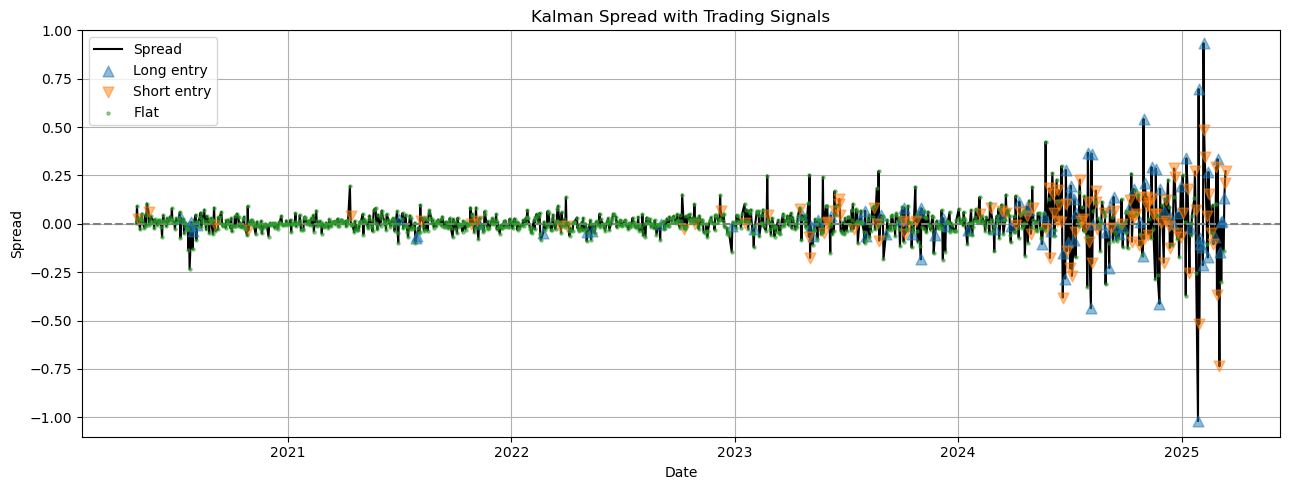

In [8]:
plt.figure(figsize=(13, 5))
plt.plot(df.index, df["dspread"], color="black", label="Spread")
plt.ylim(-1.1,1.0)
plt.axhline(0, color="grey", ls="--")

plt.scatter(df.index[df["position"] ==  1],
            df["dspread"][df["position"] ==  1],
            marker="^", s=60, alpha=0.5, label="Long entry", zorder=3)

plt.scatter(df.index[df["position"] == -1],
            df["dspread"][df["position"] == -1],
            marker="v", s=60, alpha=0.5, label="Short entry", zorder=3)

plt.scatter(df.index[(df["position"] == 0) & (signal == 0)],
            df["dspread"][(df["position"] == 0) & (signal == 0)],
            marker="o", s=5, alpha=0.5, label="Flat", zorder=3)

plt.title("Kalman Spread with Trading Signals")
plt.xlabel("Date");  plt.ylabel("Spread")
plt.grid();  plt.legend();  plt.tight_layout()
plt.show()


In [13]:
# We define our parameters, starting with $100,000 as our initial investment, and $10,000
# as capital per point (capital per point gives us our exposure to a single 
#point movement in spread, using 10,000 gives us a 10% exposure per point) 
# we use 30 as our duration in order to maintain accuracy
capital_per_point = 10000
capital = 100000
period = 30

# we begin calculationg pnl
df["pnl"] = df["position"].shift(1) * df["dspread"].diff() * capital_per_point
df["pnl"].fillna(0, inplace=True)
df["equity"] = df["pnl"].cumsum()
df["r_eq"] = df["pnl"] / capital

# we dfine and calculate our performance metrics
# risk_free = 0
# daily_free = risk_free / period
# excess = df["r_eq"].mean() - daily_free
# print(excess)
sharpe = df["r_eq"].mean() / df["r_eq"].std(ddof=1) * np.sqrt(period)
cumulative_max = df["equity"].cummax()
drawdowns = df["equity"] - cumulative_max
max_drawdown = drawdowns.min()
total_pnl = df["equity"].iloc[-1]

# we close off our last trade, making sure we have no open positions after trading
df.at[df.index[-1], "position"] = 0


# we ascertain the character of our positions, we are setting a 20 day max holding
# period in order to limit risk and avoid overfitting
max_days = 20  
trade_log = []
position = False
entry_eq = None
entry_pos = None
entry = None

for date, row in df.iterrows():
    pos = row["position"]

    if not position and pos != 0:
        # Trade entry
        position  = True
        entry = date
        entry_eq = row["equity"]
        entry_pos = pos

    elif position :
        # Check normal exit or max holding period
        exit_now = False

        if pos == 0:
            exit_now = True
        elif (date - entry).days >= max_days:
            exit_now = True

        if exit_now:
            exit = date
            exit_equity = row["equity"]
            pnl_trade = exit_equity - entry_eq
            trade_log.append({
                "Entry Date": entry,
                "Exit Date": exit,
                "Direction": "Long" if entry_pos == 1 else "Short",
                "PnL": pnl_trade,
                "Holding Period": (exit - entry).days
            })
            position  = False

# We build up a log of trades in order to understand the behaviour of our model 
if trade_log:
    trades_df = pd.DataFrame(trade_log)
    trade_pnls = trades_df["PnL"].values
    win = trade_pnls[trade_pnls > 0]
    losses = trade_pnls[trade_pnls < 0]

    win_loss_ratio = len(win) / len(losses) if len(losses) > 0 else np.nan
    avg_win = win.mean() if len(win) > 0 else 0
    avg_loss = losses.mean() if len(losses) > 0 else 0
else:
    trades_df = pd.DataFrame()
    win_loss_ratio = np.nan
    avg_win = avg_loss = 0

# We summarise our trades 
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: ${max_drawdown:,.0f}")
print(f"Total P&L: ${total_pnl:,.0f}")
print(f"Number of Trades: {len(trades_df)}")
print(f"Win/Loss Ratio: {win_loss_ratio:.2f}")
print(f"Avg Win / Avg Loss: {avg_win:.0f} / {avg_loss:.0f}")

# we tabulate our trades 



Sharpe Ratio: -0.03
Max Drawdown: $-26,713
Total P&L: $-7,806
Number of Trades: 121
Win/Loss Ratio: 1.20
Avg Win / Avg Loss: 1147 / -1542


In [10]:
# PICHU 
# Parameter grids
qs = [1e-5, 1e-4, 1e-3]
r_vals = [0.5, 1.0, 2.0]
z_enter_v = [0.8, 1.0, 1.2]
z_exit_v = [0.2, 0.5]
hold_vals = [10, 20, 30]

capital_per_point = 10000
capital = 100000
period = 90
exclusion = 30

results = []

for q, r, Z_ent, z_ex, max_days in itertools.product(qs, r_vals, z_enter_v, z_exit_v, hold_vals):
   
        dbeta = kalman_beta(df["NVDA"].values, df["AMD"].values, q=q, r=r)
        df_excl = df.iloc[exclusion:].copy()
        beta_excl = dbeta[exclusion:]

        df_excl["dbeta"] = beta_excl
        df_excl["spread"] = df_excl["NVDA"] - df_excl["dbeta"] * df_excl["AMD"]

        # Z-score signal
        z = (df_excl["spread"] - df_excl["spread"].mean()) / df_excl["spread"].std()
        signal= pd.Series(0, index=df_excl.index)
        signal[z < -Z_ent] = 1
        signal[z > Z_ent] = -1
        signal[z.abs() < z_ex] = 0
        signal= signal.shift(1).fillna(0).astype(int)
#
        pos = signal.copy()
        for i in range(1, len(pos)):
            if signal.iloc[i] == 0:
                pos.iloc[i] = pos.iloc[i-1] if pos.iloc[i-1] != 0 else 0
        df_excl["position"] = pos

#
        df_excl.at[df_excl.index[-1], "position"] = 0

        position = False
        entry = None
        entry_eq = None
        entry_pos = None
        trade_log = []

        df_excl["pnl"] = df_excl["position"].shift(1) * df_excl["spread"].diff() * capital_per_point
        df_excl["pnl"].fillna(0, inplace=True)
        df_excl["equity"] = df_excl["pnl"].cumsum()

        for date, row in df_excl.iterrows():
            pos = row["position"]
            if not position and pos != 0:
                position = True
                entry = date
                entry_eq = row["equity"]
                entry_pos = pos
            elif position:
                if pos == 0 or (date - entry).days >= max_days:
                    exit = date
                    exit_equity = row["equity"]
                    pnl_trade = exit_equity - entry_eq
                    trade_log.append(pnl_trade)
                    position = False

        df_excl["r_eq"] = df_excl["pnl"] / capital
        sharpe = df_excl["r_eq"].mean() / df_excl["r_eq"].std(ddof=1) * np.sqrt(period)
        total_pnl = df_excl["equity"].iloc[-1]
        cumulative_max = df_excl["equity"].cummax()
        drawdowns = df_excl["equity"] - cumulative_max
        max_drawdown = drawdowns.min()

        trade_pnls = np.array(trade_log)
        win= trade_pnls[trade_pnls > 0]
        lose = trade_pnls[trade_pnls < 0]
        win_loss_ratio = len(win) / len(lose) if len(lose) > 0 else np.nan
        avg_loss = lose.mean() if len(lose) > 0 else 0
        avg_win = win.mean() if len(win) > 0 else 0
        
        results.append({
            "q": q, "r": r,
            "Entry Z Value": Z_ent, "Exit Z Value": z_ex,
            "Maximum Holding": max_days,
            "Sharpe": sharpe,
            "Total Profit and Loss": total_pnl,
            "Maximum Drawdown": max_drawdown,
            "Win/Loss": win_loss_ratio,
            "Avg Gain": avg_win,
            "Avg Loss": avg_loss,
            "Trades": len(trade_pnls)
        })

# we tabulate our results into a dataframe
results_df = pd.DataFrame(results)
results_df.sort_values(by="Sharpe", ascending=False).head()

,q,r,Entry Z Value,Exit Z Value,Maximum Holding,Sharpe,Total Profit and Loss,Maximum Drawdown,Win/Loss,Avg Gain,Avg Loss,Trades
0,0.00001,0.5,0.8,0.2,10,0.914136,1.352996e+06,-137737.649988,1.660377,17946.351258,-7017.733049,141
1,0.00001,0.5,0.8,0.2,20,0.914136,1.352996e+06,-137737.649988,1.454545,29987.112688,-7309.396566,81
2,0.00001,0.5,0.8,0.2,30,0.914136,1.352996e+06,-137737.649988,1.789474,40855.544400,-5850.684380,53
3,0.00001,0.5,0.8,0.5,10,0.914136,1.352996e+06,-137737.649988,1.660377,17946.351258,-7017.733049,141
4,0.00001,0.5,0.8,0.5,20,0.914136,1.352996e+06,-137737.649988,1.454545,29987.112688,-7309.396566,81


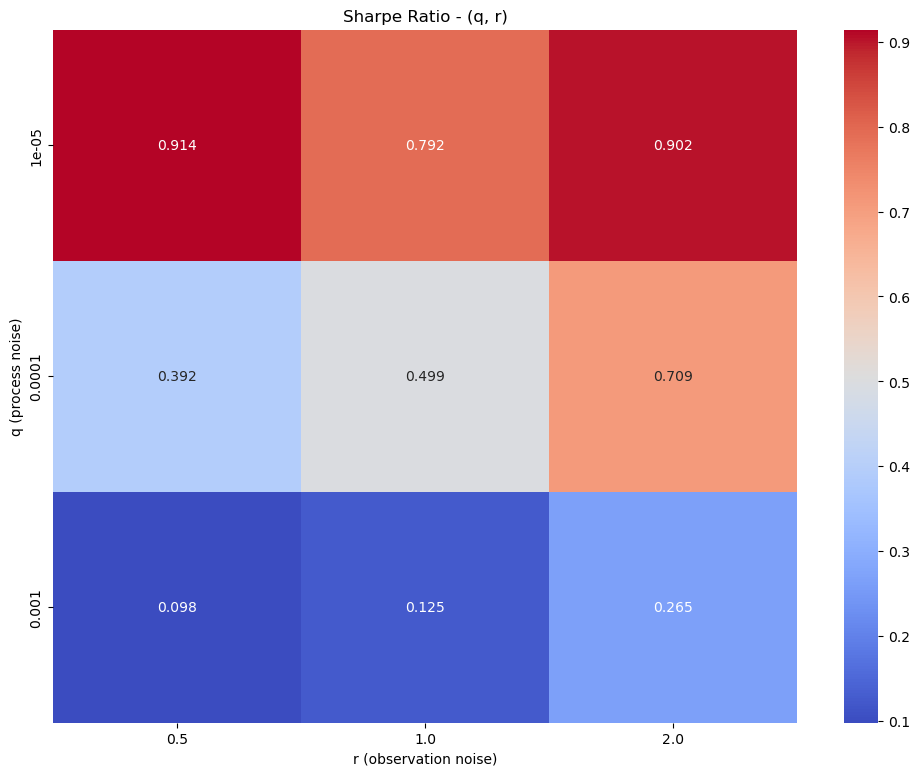

In [14]:
# We build up a heatmap for our varying q and r values, in order to ascertain the 
# best values for this 
q_r = results_df.sort_values("Sharpe", ascending=False).drop_duplicates(subset=["q", "r"])
table= q_r.pivot(index="q", columns="r", values="Sharpe")
plt.figure(figsize=(12, 9))
sns.heatmap(table, annot=True, fmt=".3f", cmap="coolwarm")
plt.title("Sharpe Ratio - (q, r)")
plt.ylabel("q (process noise)")
plt.xlabel("r (observation noise)")
plt.show()

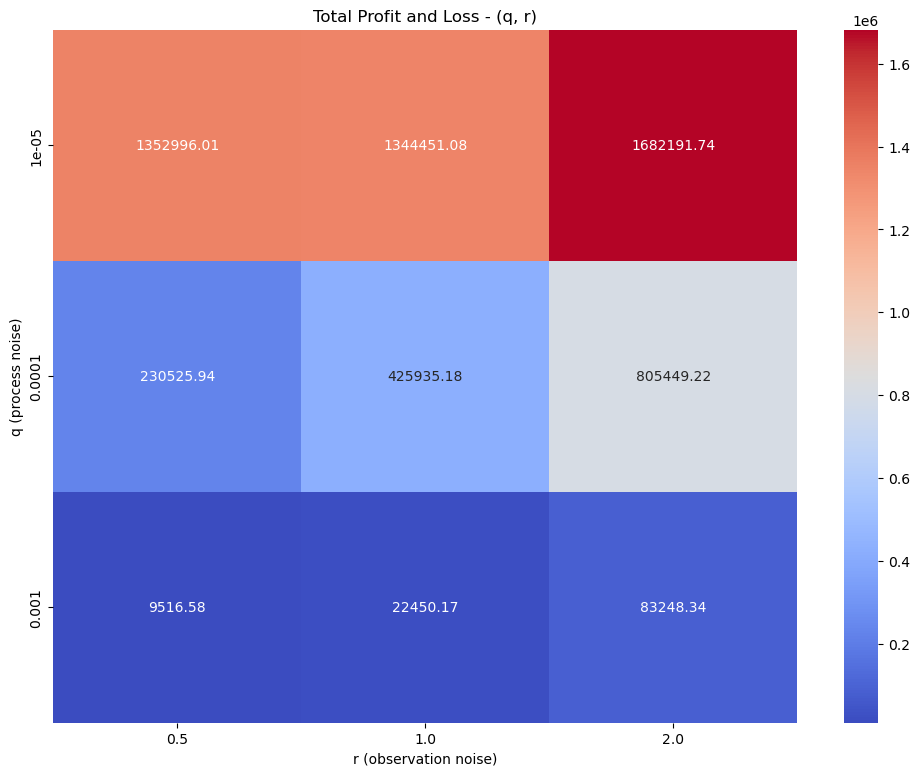

In [19]:
# we do the same to calculate our total PNL
q_r = results_df.sort_values("Sharpe", ascending=False).drop_duplicates(subset=["q", "r"])
table = q_r.pivot(index="q", columns="r", values="Total Profit and Loss")
plt.figure(figsize=(12, 9))
sns.heatmap(table, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Total Profit and Loss - (q, r)")
plt.xlabel("r (observation noise)")
plt.ylabel("q (process noise)")
plt.show()


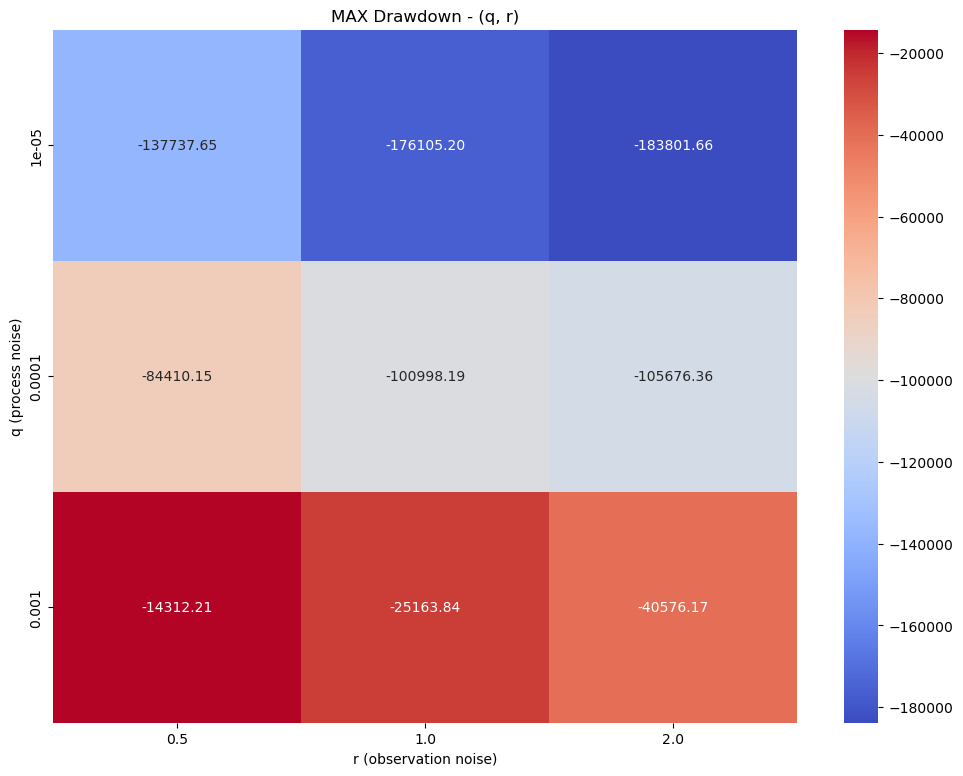

In [18]:
# we do the same to calculate our max drawdown 
q_r = results_df.sort_values("Sharpe", ascending=False).drop_duplicates(subset=["q", "r"])
table = q_r.pivot(index="q", columns="r", values="Maximum Drawdown")
plt.figure(figsize=(12, 9))
sns.heatmap(table, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("MAX Drawdown - (q, r)")
plt.xlabel("r (observation noise)")
plt.ylabel("q (process noise)")
plt.show()
